# Лабораторная работа №3 «Кластерный анализ данных»

### Вариант 6

## Импорты и базовые параметры / Метрики расстояний и вспомогательные функции

In [38]:
import numpy as np
from scipy.spatial import distance
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch

p = 3
q = 4
w = [0.19, 0.25, 0.20, 0.36]

def euclidean(a, b):
    return distance.euclidean(a, b)

def manhattan(a, b):
    return distance.cityblock(a, b)

def euclidean_w(a, b):
    return distance.euclidean(a, b, w)

def stepen(a, b):
    sum_ = sum(abs(a[e] - b[e]) ** p for e in range(len(a)))
    return sum_ ** (1 / q)

def calc_centroid(a):
    return np.mean(a, axis=0)


## Класс кластера и алгоритм агломеративной кластеризации

In [39]:
all_type = {
    'евклидово': euclidean,
    'манхэттенское': manhattan,
    'взвешенное евклидово': euclidean_w,
    'степенное': stepen
}

class Cluster:
    def __init__(self, objects, distance=0.0, name=None):
        self.name = name
        self.distance = distance
        self.objects = objects

    def get_distance(self, cluster, type_calc, is_min=True):
        base = all_type[type_calc](self.objects[0], cluster.objects[0])
        for obj in self.objects:
            for other in cluster.objects:
                d = all_type[type_calc](obj, other)
                if is_min and d < base:
                    base = d
                elif not is_min and d > base:
                    base = d
        return base

    def get_distance_centroid(self, cluster, type_calc):
        return all_type[type_calc](
            calc_centroid(self.objects), calc_centroid(cluster.objects)
        )

    def get_distance_average(self, cluster, type_calc):
        total = sum(all_type[type_calc](a, b)
                    for a in self.objects for b in cluster.objects)
        return total / (len(self.objects) + len(cluster.objects))


class CalcSimilar:
    def __init__(self, df, max_len_cluster, type_calc):
        self.df = df
        self.max_len_cluster = max_len_cluster
        self.type_calc = type_calc

    def calculate(self, method):
        methods = {
            'одиночной связи': self.near_neighbor,
            'полных связей': self.dist_neighbor,
            'центроидный': self.centroid,
            'средних связей': self.average_linkage,
            'Уорда': self.ward
        }
        return methods[method]()

    def cluster_iter(self, dist_func):
        clusters = [Cluster([self.df[i]], 0, i) for i in range(len(self.df))]
        final_clusters = []

        while len(clusters) > 1:
            min_dist = float('inf')
            pair = None
            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    d = dist_func(clusters[i], clusters[j])
                    if d < min_dist and len(clusters[i].objects) + len(clusters[j].objects) <= self.max_len_cluster:
                        min_dist = d
                        pair = (i, j)

            if pair is None:
                break

            i, j = pair
            new_cluster = Cluster(clusters[i].objects + clusters[j].objects, min_dist)

            # Удаляем объединившиеся кластеры
            for idx in sorted([i, j], reverse=True):
                del clusters[idx]

            # Если достигли макс. размера — сразу кидаем в результат
            if len(new_cluster.objects) == self.max_len_cluster:
                final_clusters.append(new_cluster)
            else:
                clusters.append(new_cluster)

        # Добавляем оставшиеся кластеры, если они не пустые
        final_clusters.extend([c for c in clusters if len(c.objects) <= self.max_len_cluster])

        # Преобразуем в индексы
        results = []
        for cluster in final_clusters:
            cl_idx = []
            for obj in cluster.objects:
                for idx, orig in enumerate(self.df):
                    if np.array_equal(obj, orig):
                        cl_idx.append(idx)
                        break
            cl_idx.sort()
            if cl_idx not in results:
                results.append(cl_idx)

        return results


    def near_neighbor(self):
        return self.cluster_iter(lambda a, b: a.get_distance(b, self.type_calc, True))

    def dist_neighbor(self):
        return self.cluster_iter(lambda a, b: a.get_distance(b, self.type_calc, False))

    def centroid(self):
        return self.cluster_iter(lambda a, b: a.get_distance_centroid(b, self.type_calc))

    def average_linkage(self):
        return self.cluster_iter(lambda a, b: a.get_distance_average(b, self.type_calc))

    def ward(self):
        labels = np.arange(len(self.df))
        clusters = [[x] for x in self.df]
        while len(clusters) > 1:
            min_dist = float('inf')
            best = None
            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    if len(clusters[i]) + len(clusters[j]) <= self.max_len_cluster:
                        d = self.ward_distance(clusters[i], clusters[j])
                        if d < min_dist:
                            min_dist = d
                            best = (i, j)
            if best is None:
                break
            i, j = best
            clusters[i].extend(clusters.pop(j))
        result = [[] for _ in range(len(clusters))]
        for i, cluster in enumerate(clusters):
            for obj in cluster:
                idx = self.df.index(obj)
                result[i].append(idx)
        return [r for r in result if r]

    def ward_distance(self, a, b):
        n1, n2 = len(a), len(b)
        m1, m2 = np.mean(a, axis=0), np.mean(b, axis=0)
        return (n1 * n2) / (n1 + n2) * all_type[self.type_calc](m1, m2)



## Входные данные (таблица объектов)

In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations

raw_data = '''
98 74 95 24 18 30 78 95 58 74 97 12 52 92 96 98 18 41 46 86 43 31 24 93 49 84 53
59 34 10 24 55 27 66 29 57 54 10 13 72 22 42 25 74 88 67 17 18 99 73 42 30 71 17
30 86 12 42 55 33 44 54 72 72 80 69 88 75 45 99 13 73 90 84 33 37 47 88 29 85 54
37 81 93 12 31 97 49 33 53 36 62 61 76 91 33 34 99 94 69 79 39 86 70 43 47 48 66
'''


rows = raw_data.strip().split('\n')
data = np.array([[int(x) for x in r.strip().split()] for r in rows]).T
df = pd.DataFrame(data, columns=['X1', 'X2', 'X3', 'X4'])

display(df.head())
print(f"Объектов: {df.shape[0]}, Признаков: {df.shape[1]}")


,X1,X2,X3,X4
0,98,59,30,37
1,74,34,86,81
2,95,10,12,93
3,24,24,42,12
4,18,55,55,31


Объектов: 27, Признаков: 4


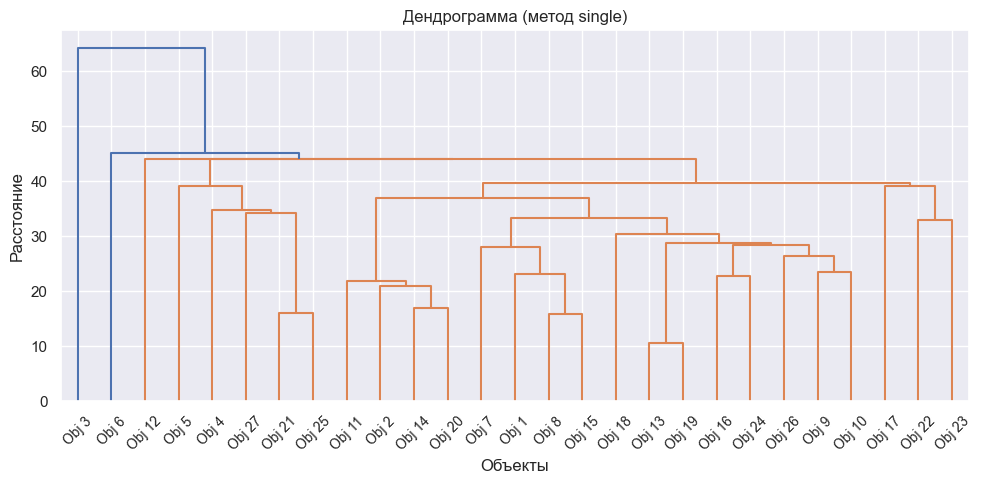

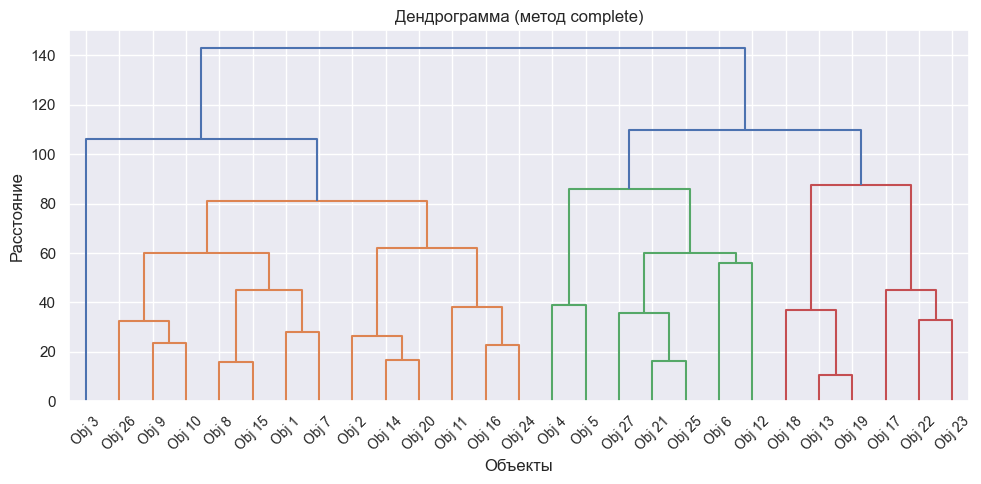

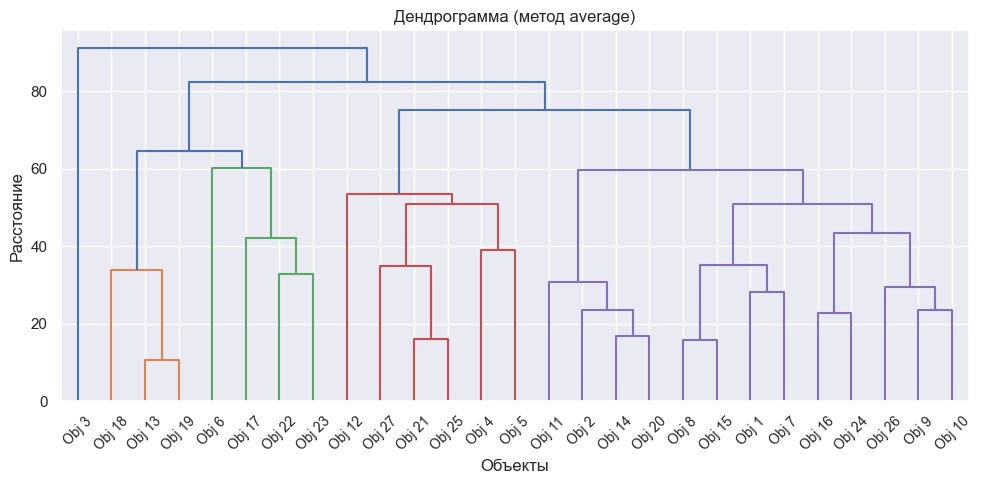

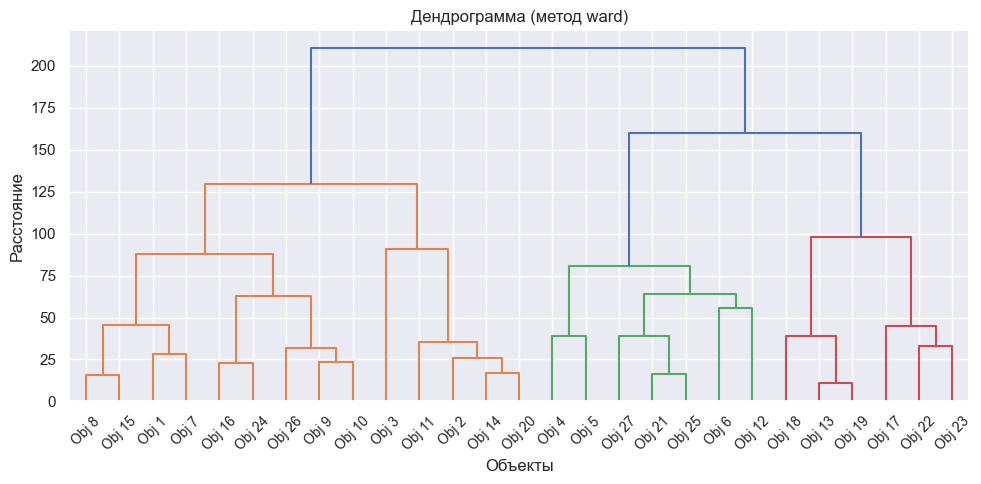

In [41]:
linkage_methods = ['single', 'complete', 'average', 'ward']
sns.set()

for method in linkage_methods:
    plt.figure(figsize=(10, 5))
    dendrogram = sch.dendrogram(
        sch.linkage(df.values, method=method),
        labels=[f"Obj {i+1}" for i in range(len(df))]
    )
    plt.title(f"Дендрограмма (метод {method})")
    plt.xlabel("Объекты")
    plt.ylabel("Расстояние")
    plt.tight_layout()
    plt.show()

## Построение всех 6 комбинаций кластеризаций

In [42]:
from IPython.display import display, Markdown
import pandas as pd

for method_un in methods_union:
    for method_sim in methods_sim:
        model = CalcSimilar(df_list, max_cl, method_sim)
        clusters = model.calculate(method_un)

        cluster_matrix[(method_un, method_sim)] = clusters

        display(Markdown(f"### 🔹 Метод: **{method_un}** | Метрика: **{method_sim}**"))

        # Формируем таблицу
        cluster_data = {
            "Номер кластера": [],
            "Объекты (нумерация с 1)": []
        }

        for i, cl in enumerate(clusters, 1):
            cluster_data["Номер кластера"].append(f"Кластер {i}")
            cluster_data["Объекты (нумерация с 1)"].append(", ".join(str(x + 1) for x in sorted(cl)))

        df_clusters = pd.DataFrame(cluster_data)
        display(df_clusters)


### 🔹 Метод: **одиночной связи** | Метрика: **степенное**

,Номер кластера,Объекты (нумерация с 1)
0,Кластер 1,"9, 10, 13, 18, 19, 26"
1,Кластер 2,"2, 11, 14, 16, 20, 24"
2,Кластер 3,"4, 5, 6, 21, 25, 27"
3,Кластер 4,"12, 17, 22, 23"
4,Кластер 5,"1, 3, 7, 8, 15"


### 🔹 Метод: **одиночной связи** | Метрика: **взвешенное евклидово**

,Номер кластера,Объекты (нумерация с 1)
0,Кластер 1,"13, 17, 18, 19, 22, 23"
1,Кластер 2,"4, 5, 12, 21, 25, 27"
2,Кластер 3,"2, 3, 6, 11, 14, 20"
3,Кластер 4,"9, 10, 16, 24, 26"
4,Кластер 5,"1, 7, 8, 15"


### 🔹 Метод: **средних связей** | Метрика: **степенное**

,Номер кластера,Объекты (нумерация с 1)
0,Кластер 1,"13, 17, 18, 19, 22, 23"
1,Кластер 2,"2, 11, 14, 20"
2,Кластер 3,"6, 12, 27"
3,Кластер 4,"1, 7, 8, 15"
4,Кластер 5,"9, 10, 16, 24, 26"
5,Кластер 6,"3, 4, 5, 21, 25"


### 🔹 Метод: **средних связей** | Метрика: **взвешенное евклидово**

,Номер кластера,Объекты (нумерация с 1)
0,Кластер 1,"4, 5, 12, 21, 25, 27"
1,Кластер 2,"2, 11, 14, 20"
2,Кластер 3,"1, 7, 8, 15"
3,Кластер 4,"9, 10, 16, 24, 26"
4,Кластер 5,"3, 6, 17"
5,Кластер 6,"13, 18, 19, 22, 23"


### 🔹 Метод: **Уорда** | Метрика: **степенное**

,Номер кластера,Объекты (нумерация с 1)
0,Кластер 1,"1, 7, 8, 15"
1,Кластер 2,"2, 11, 14, 20"
2,Кластер 3,"3, 6, 12, 27"
3,Кластер 4,"4, 5, 21, 25"
4,Кластер 5,"9, 10, 16, 24, 26"
5,Кластер 6,"13, 17, 18, 19, 22, 23"


### 🔹 Метод: **Уорда** | Метрика: **взвешенное евклидово**

,Номер кластера,Объекты (нумерация с 1)
0,Кластер 1,"1, 7, 8, 15"
1,Кластер 2,"2, 3, 11, 14, 20"
2,Кластер 3,"4, 5, 12, 21, 25, 27"
3,Кластер 4,"6, 17, 22, 23"
4,Кластер 5,"9, 10, 16, 24, 26"
5,Кластер 6,"13, 18, 19"


## Подсчёт устойчивых пар объектов / Анализ устойчивости (по методам и метрикам)

In [43]:
from itertools import combinations

all_pairs = list(combinations(range(len(df)), 2))

def count_stable_pairs(cluster_sets: list[list[list[int]]]) -> int:
    pair_counter = {pair: 0 for pair in all_pairs}
    for clustering in cluster_sets:
        for cluster in clustering:
            for a, b in combinations(cluster, 2):
                pair = tuple(sorted((a, b)))
                pair_counter[pair] += 1
    return sum(1 for v in pair_counter.values() if v == len(cluster_sets))


#  1. Вариации метрики при фиксированном методе
display(Markdown("## 🔹 Вариации метрики при фиксированном методе"))

rows = []
for method_un in methods_union:
    cluster_sets = [cluster_matrix[(method_un, sim)] for sim in methods_sim]
    stable = count_stable_pairs(cluster_sets)
    rows.append([method_un, stable])
df_metric_fixed = pd.DataFrame(rows, columns=["Метод кластеризации", "Устойчивых пар"])
display(df_metric_fixed)

#  2. Вариации метода при фиксированной метрике
display(Markdown("## 🔹 Вариации метода при фиксированной метрике"))

rows = []
for method_sim in methods_sim:
    cluster_sets = [cluster_matrix[(union, method_sim)] for union in methods_union]
    stable = count_stable_pairs(cluster_sets)
    rows.append([method_sim, stable])
df_method_fixed = pd.DataFrame(rows, columns=["Метрика", "Устойчивых пар"])
display(df_method_fixed)

# 3. Полный пересчёт
display(Markdown("## 🔹 Полный пересчёт (все комбинации)"))
stable_total = count_stable_pairs(list(cluster_matrix.values()))
df_total = pd.DataFrame([["Все комбинации", stable_total]], columns=["Комбинация", "Устойчивых пар"])
display(df_total)




## 🔹 Вариации метрики при фиксированном методе

,Метод кластеризации,Устойчивых пар
0,одиночной связи,32
1,средних связей,39
2,Уорда,35


## 🔹 Вариации метода при фиксированной метрике

,Метрика,Устойчивых пар
0,степенное,29
1,взвешенное евклидово,41


## 🔹 Полный пересчёт (все комбинации)

,Комбинация,Устойчивых пар
0,Все комбинации,26


## Визуализация результата кластеризации (тепловая карта)

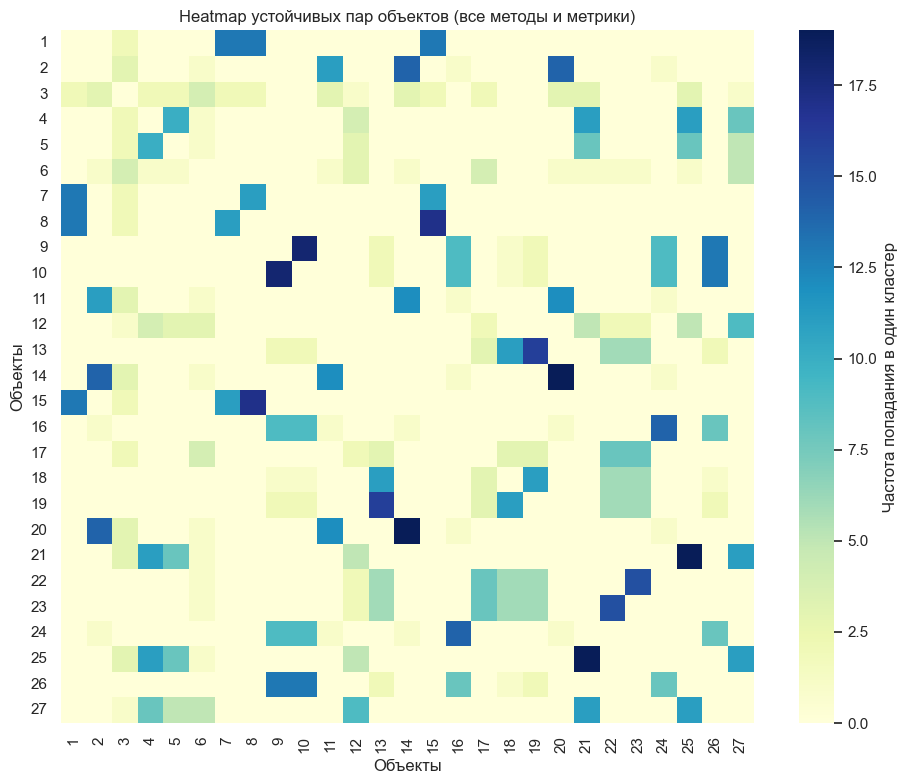

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Генерация полной матрицы устойчивых пар на основе всех 6 комбинаций
def build_pair_matrix(cluster_group, n_objs):
    matrix = np.zeros((n_objs, n_objs))
    for config in cluster_group:
        for cluster in config:
            for i in range(len(cluster)):
                for j in range(i + 1, len(cluster)):
                    a, b = cluster[i], cluster[j]
                    matrix[a, b] += 1
                    matrix[b, a] += 1
    return matrix

pair_matrix = build_pair_matrix(th_an, len(df))  # Используем все комбинации
sns.set()

plt.figure(figsize=(10, 8))
sns.heatmap(pair_matrix, cmap="YlGnBu", square=True, cbar_kws={'label': 'Частота попадания в один кластер'})
plt.title("Heatmap устойчивых пар объектов (все методы и метрики)")
plt.xlabel("Объекты")
plt.ylabel("Объекты")
plt.xticks(ticks=np.arange(len(df)) + 0.5, labels=[str(i+1) for i in range(len(df))], rotation=90)
plt.yticks(ticks=np.arange(len(df)) + 0.5, labels=[str(i+1) for i in range(len(df))], rotation=0)
plt.tight_layout()
plt.show()
